# Case where Single Neuron gets an input from N-2 neurons

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook

In [2]:
TAU_TWO = 0.3
TAU_FALL= 0.45
THRESHOLD= -30.0
INCREMENT =100 

CM  = 1.00  # /*uF/cm2*/
I_APP = 0.00 # /*uA/cm2*/

E_NA =  50.0
E_K  = -90.0
E_L  = -71.975 # //-70.4
E_SYN_SH =  -55.0 #reversal potential of GABA_Asynapse - determines shunt (-55) 
E_SYN_H =  -75.0 #reversal potential of GABA_Asynapse - determines hyperpolarizing (-75) 
#E_SYN =  -75.0 #reversal potential of GABA_Asynapse - determines shunt (-55) versus hyperpolarizing (-75) 

G_NA = 218.8 # //239.13  mS/cm2 all conductances were divided by 0.000096 cm2
G_K3 =  8.225 # // 10.22469
G_K1 =  0.769 # // 1.1058
G_L  = 0.1915 # // 0.2224

G_SYN =   23*0.0214844 #single synapse value is 0.02391 mS/cm2*/ 
G_SYN2 =  0.09115 # // equal to 7 nS ChR*/ channel rhodopsin conductance
G_SYN3 =  0*0.0214844 # // autapse single synapse value

#DELAY = 0.8

THETA_M = -52.995 # // -56.42
SIGMA1_M = 4.0
SIGMA2_M = -13.0
K1_M = 0.25
K2_M = 0.1

THETA_H = -55.711 # //-56.59
SIGMA1_H = -20.0
SIGMA2_H = 3.5
K1_H = 0.012
K2_H = 0.2

THETA_N = 5.9 # // -4.23
SIGMA1_N = 12.0
SIGMA2_N = -8.5
K1_N = 1.0 
K2_N = 0.001

THETA_A = 51.355 # // 51.4
SIGMA1_A = 12.0
SIGMA2_A = -80.0
K1_A = 1.0 
K2_A = 0.02

ALPHA = 6.25 # /* ms */
TAUSYN = 1.0 # /*  1.0 3.0 2.0   */
SS1 = 0.00
SS2 = 0.00
I_STIM = 0.0

#Defining some functions that are required for the routine

def boltz(V,half,slope): 
    arg = -(V-half)/slope
    if( (arg>50.0) or (arg<-50) ):
        if(arg>50):
            return(0.0)
        else:
            return(1.0)
    else:
        return(1.0/(1.0 + np.exp(arg)))

def gaussian(v,a,b,c,d):
    arg = ((v-c)/b)**2
    if( (arg>50.0) or (arg<-50) ):
        if(arg>50):
            return(d)
        else:
            return(d+a)
    else:
        return((d + a*np.exp(-arg)))

def efun(z):
    if(abs(z) < 1e-4):
        return(1 - z/2)
    else:
        return(z/(np.exp(z) - 1))
    
def alpha(v,k,theta,sigma):
    arg = (theta-v)/sigma
    if(v == theta):
        return(k*sigma)
    else:
        if( (arg>50.0) or (arg<-50) ):
            if(arg>50.0): 
                return(0.0)
            else:
                return(k*(v - theta))
        else:
            return(k*(theta-v)/(np.exp(arg) - 1.0))

def beta(v,k,sigma):
    return(k*np.exp(v/sigma))

#This function identifies the onset of a spike, the first time the threshold is crossed
def spike(x,t):
    'An event when V1 >= THRESHOLD'
    if (t == 0.0):
        return 0
    
    if (x[0] >= THRESHOLD):
        return 1
    else:
        return 0
    
#Functions for Synaptic Currents 
def I_NA(V, M, H): return G_NA * (M**3) * H * (V - E_NA)
def I_K1(V,A): return G_K1 * (A**4) * (V - E_K)
def I_L(V): return G_L * (V - E_L)
def I_K3(V,N): return G_K3 * (N**4) * (V - E_K)
def I_S1(V,gsyn1):   return gsyn1 * (V - E_SYN_H)
def I_S2(V):   return G_SYN2 * V
def I_S3(V,G): return G * (V - E_SYN_H)

In [3]:
def Euler_Via(intitial_values,tf,N,delta):
    e = [spike(initial_values[0],0)]
    #print(N)
    Autapse_Times = []
    t_autapse = -1
    gsyn1 = 0.0
    t = np.linspace(0,tf,N+1)
    dt = tf/N

    #Defining the State, Co-State and Control Variables as Vectors
    V = np.zeros(len(t))
    H = np.zeros(len(t))
    N = np.zeros(len(t))
    A = np.zeros(len(t))
    M = np.zeros(len(t))
    X = np.zeros(len(t))
    G = np.zeros(len(t))

    #Assigning the initial values
    V[0] = initial_values[0]
    H[0] = initial_values[1]
    N[0] = initial_values[2]
    A[0] = initial_values[3]
    M[0] = initial_values[4]
    X[0] = initial_values[5]
    G[0] = initial_values[6]
 
    sol = [initial_values]
    
    for i in range(len(t) - 1):
        if(round(t[i],3) == round(t_autapse,3)):
        #if(t[i] == t_autapse):
            #print(t[i],t_autapse)
            X[i] = X[i] + G_SYN3  
            
        V[i+1] = V[i] + ((dt*(I_STIM - I_S2(V[i]) - I_NA(V[i],M[i],H[i]) - I_K1(V[i],A[i]) - I_K3(V[i],N[i]) - I_L(V[i]) - I_S1(V[i],gsyn1) - I_S3(V[i],G[i]))) / CM)
        H[i+1] = H[i] + dt*(beta(V[i],K1_H,SIGMA1_H)*(1.0 - H[i]) - alpha(V[i],K2_H,THETA_H,SIGMA2_H)*H[i])
        N[i+1] = N[i] + dt*(alpha(V[i],K1_N,THETA_N,SIGMA1_N)*(1.0 - N[i]) - beta(V[i],K2_N,SIGMA2_N)*N[i])
        A[i+1] = A[i] + dt*(alpha(V[i],K1_A,THETA_A,SIGMA1_A)*(1.0 - A[i]) - beta(V[i],K2_A,SIGMA2_A)*A[i])
        M[i+1] = M[i] + dt*(alpha(V[i],K1_M,THETA_M,SIGMA1_M)*(1.0 - M[i]) - beta(V[i],K2_M,SIGMA2_M)*M[i])
        X[i+1] = X[i] + dt*(-X[i]/TAU_TWO)
        G[i+1] = G[i] + dt*(((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * X[i]) - G[i])/TAU_FALL)
        
        sol+=[[V[i+1]]]
        
        e += [spike(sol[-1],t[-1])]
        if ((e[-1]==1) and (e[-2] == 0)):
            t_autapse = t[i] + delta
            Autapse_Times.append(t_autapse)
            #print('Autapse times',t_autapse)
         
    return sol 

In [4]:
def Euler_Via_Perturb(intitial_values,tf,N,ts,delta):
    e = [spike(initial_values[0],0)]
    #print(N)
    Autapse_Times = []
    t_autapse = -1
    gsyn1 = 0.0
    t = np.linspace(0,tf,N+1)
    dt = tf/N

    #Defining the State, Co-State and Control Variables as Vectors
    V = np.zeros(len(t))
    H = np.zeros(len(t))
    N = np.zeros(len(t))
    A = np.zeros(len(t))
    M = np.zeros(len(t))
    X = np.zeros(len(t))
    G = np.zeros(len(t))

    #Assigning the initial values
    V[0] = initial_values[0]
    H[0] = initial_values[1]
    N[0] = initial_values[2]
    A[0] = initial_values[3]
    M[0] = initial_values[4]
    X[0] = initial_values[5]
    G[0] = initial_values[6]
 
    sol = [initial_values]
    
    arg = (TAU_TWO*TAU_FALL) * ((np.log(TAU_FALL/TAU_TWO))/(TAU_FALL-TAU_TWO))
    f = 1.0/(np.exp(-arg/TAU_FALL) - np.exp(-arg/TAU_TWO))
    
    for i in range(len(t) - 1):
        if (t[i] < ts): 
            gsyn1 = 0.0 #Allowing the first three spikes as a freely oscillating neuron 
        else:
            gsyn1 = f*G_SYN*(np.exp((ts - t[i])/TAU_FALL) - np.exp((ts - t[i])/TAU_TWO))

        if(round(t[i],3) == round(t_autapse,3)):
        #if(t[i] == t_autapse):
            #print(t[i],t_autapse)
            X[i] = X[i] + G_SYN3  
            
        V[i+1] = V[i] + ((dt*(I_STIM - I_S2(V[i]) - I_NA(V[i],M[i],H[i]) - I_K1(V[i],A[i]) - I_K3(V[i],N[i]) - I_L(V[i]) - I_S1(V[i],gsyn1) - I_S3(V[i],G[i]))) / CM)
        H[i+1] = H[i] + dt*(beta(V[i],K1_H,SIGMA1_H)*(1.0 - H[i]) - alpha(V[i],K2_H,THETA_H,SIGMA2_H)*H[i])
        N[i+1] = N[i] + dt*(alpha(V[i],K1_N,THETA_N,SIGMA1_N)*(1.0 - N[i]) - beta(V[i],K2_N,SIGMA2_N)*N[i])
        A[i+1] = A[i] + dt*(alpha(V[i],K1_A,THETA_A,SIGMA1_A)*(1.0 - A[i]) - beta(V[i],K2_A,SIGMA2_A)*A[i])
        M[i+1] = M[i] + dt*(alpha(V[i],K1_M,THETA_M,SIGMA1_M)*(1.0 - M[i]) - beta(V[i],K2_M,SIGMA2_M)*M[i])
        X[i+1] = X[i] + dt*(-X[i]/TAU_TWO)
        G[i+1] = G[i] + dt*(((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * X[i]) - G[i])/TAU_FALL)
        
        sol+=[[V[i+1]]]
        
        e += [spike(sol[-1],t[-1])]
        if ((e[-1]==1) and (e[-2] == 0)):
            t_autapse = t[i] + delta
            Autapse_Times.append(t_autapse)
            #print('Autapse times',t_autapse)
         
    return sol 

# N = 25, so 1 neuron gets a total of 23 inputs

In [5]:
N = 25
G_SYN =   (N-2)*0.0214844 #single synapse value is 0.02391 mS/cm2*/ 
G_SYN2 =  0.09115 # // equal to 7 nS ChR*/ channel rhodopsin conductance
G_SYN3 =  0*0.0214844 # // autapse single synapse value

Spikes at [0.0, 5.9319999999999995, 11.866666666666667, 17.818666666666665, 23.782666666666668, 29.750666666666664, 35.72266666666667, 41.69466666666666, 47.668, 53.64266666666666, 59.616, 65.59066666666666, 71.56533333333333, 77.53999999999999]


(0.0, 80.0)

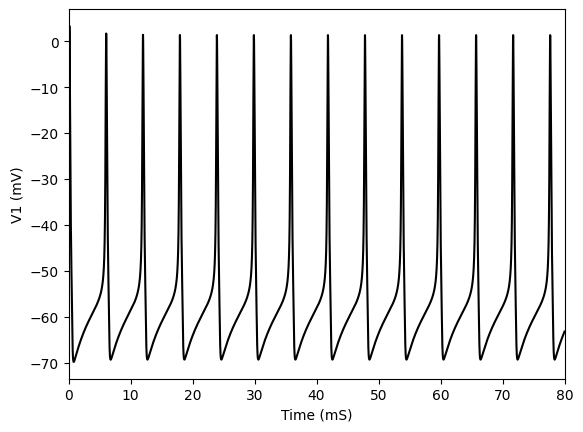

In [6]:
tf = 80
N = 60000
t = np.linspace(0,tf,N+1)
#delay_4 = np.linspace(5.0,5.9,9)
#delay_4 = np.around(delay_4,2)
#delay[0] = 0.01
#print(delay_4)

delta = 0

V1 = np.zeros(N+1)

free_running_single_4 = []

k = 0# k is the index of number of delays and it is a counter for free running numbers
#for delta in delay_4:
initial_values = [-30.00000, 0.184178, 0.582675, 0.399928, 0.465379, 0.00, 0.00]
sol = Euler_Via(initial_values,tf,N,delta)
    #if (delta > 3):
    #    tf = 100
j = 0
i = 0
for i in range(len(sol)):
        #print('i of rows each time',sol[i][0])
    V1[j] = sol[i][0]
        #print(T[j],V1[j])
    j = j+1
        
itemindex = np.where(V1[:] >= THRESHOLD)
    #print(itemindex)

for index in itemindex:
    spike_times = t[index]
    
    #print(spike_times)

previous = spike_times[0]
actual_spikes = []
actual_spikes.append(previous)   
for i in range(len(spike_times)):
    if (spike_times[i] - previous > 1 ):
        actual_spikes.append(spike_times[i])
    previous = spike_times[i]

free_running_self_4 = actual_spikes
print('Spikes at',free_running_self_4)


plt.figure()
plt.plot(t,V1, 'k', label='V1')
plt.ylabel('V1 (mV)')
plt.xlabel('Time (mS)')
plt.xlim([0, tf])
#plt.savefig('For_Delay5_0.png', format='png')

In [7]:
T1 = free_running_self_4[7]
T2 = free_running_self_4[8]
free_running_period = T2-T1
print(free_running_period)
period_free_single = T2 - T1
print(period_free_single)
epsilon = 0.01
#prc_interval = np.arange(T1+epsilon, T2-epsilon, epsilon)
prc_interval_single = np.linspace(T1+epsilon, T2, 100)
stim_interval = prc_interval_single - T1
#print(prc_interval_single)
phase_single = stim_interval/period_free_single

prc_readings_single = np.zeros((len(prc_interval_single),3))
output_single = np.zeros((len(prc_interval_single),4))

j=0
for ts in prc_interval_single:
    tf = 80
    N = 60000
    #print(ts)
    t = np.linspace(0,tf,N+1)
    
    initial_values = [-30.00000, 0.184178, 0.582675, 0.399928, 0.465379, 0.00, 0.00]
    sol = Euler_Via_Perturb(initial_values,tf,N,ts,delta)

    V1 = np.zeros(N+1)

    k = 0
    for i in range(len(sol)):
        #print('i of rows each time',sol[i][0])
        V1[k] = sol[i][0]
        #print(T[j],V1[j])
        k = k+1
    
    itemindex = np.where(V1[:] > THRESHOLD)
    
    for index in itemindex:
        spike_times = t[index]
        
    previous = spike_times[0]
    actual_spikes = []
    actual_spikes.append(previous)   
    for i in range(len(spike_times)):
        if (spike_times[i] - previous > 1 ):
            actual_spikes.append(spike_times[i])
        previous = spike_times[i]
    #print(j,ts,actual_spikes)
    diff_timings = np.zeros(len(actual_spikes))
    for p in range(len(actual_spikes) - 1):
        #print(p,actual_spikes[p+1] - actual_spikes[p],free_running_self[p+1] - free_running_self[p])
        diff_timings[p] = (actual_spikes[p+1] - actual_spikes[p]) - (free_running_self_4[p+1] - free_running_self_4[p])
    #print(diff_timings,diff_timings.shape)

    
    #print(phase_self[j],diff_timings[2:5]/period_free)
    #prc_readings.append(diff_timings)
    prc_readings_single[j,:] = diff_timings[7:10]
    output_single[j,0] = phase_single[j]
    output_single[j,1] = diff_timings[7]/period_free_single
    output_single[j,2] = diff_timings[8]/period_free_single
    output_single[j,3] = diff_timings[9]/period_free_single
    print(output_single[j,:])
    j = j+1

prc_readings_single = prc_readings_single/period_free_single
#print('The final readings required for the PRC are:',prc_readings_36)
#print(prc_readings.shape)
#print(phase.shape

#df = pd.DataFrame(output_single, columns=['Phase', 'First_Order', 'Second_Order', 'Third_Order'])
#df.to_excel('02. PRC_Self2Single_Hyper.xlsx', sheet_name='Network Perturbation')

5.973333333333336
5.973333333333336
[ 0.00167411  0.02834821 -0.00446429 -0.00223214]
[ 0.01175821  0.03415179 -0.00357143 -0.00178571]
[ 0.02184231  0.04040179 -0.00267857 -0.0015625 ]
[ 0.03192641  0.04598214 -0.00200893 -0.00133929]
[ 0.04201051  0.05133929 -0.00223214 -0.00111607]
[ 0.05209461  0.05625    -0.00200893 -0.00133929]
[ 0.06217871  0.06116071 -0.00223214 -0.00133929]
[ 0.07226281  0.06607143 -0.00245536 -0.0015625 ]
[ 0.08234691  0.07053571 -0.00267857 -0.0015625 ]
[ 0.09243101  0.075      -0.00290179 -0.00178571]
[ 0.10251511  0.07901786 -0.00290179 -0.00178571]
[ 0.11259921  0.08325893 -0.00334821 -0.00178571]
[ 0.12268331  0.08727679 -0.00334821 -0.00200893]
[ 0.13276741  0.09151786 -0.00357143 -0.00223214]
[ 0.14285151  0.09598214 -0.00401786 -0.00245536]
[ 0.15293561  0.10022321 -0.00424107 -0.00245536]
[ 0.16301971  0.1046875  -0.00446429 -0.00267857]
[ 0.17310381  0.10915179 -0.0046875  -0.00267857]
[ 0.18318791  0.11383929 -0.00491071 -0.00290179]
[ 0.19327201  

In [53]:
#df = pd.DataFrame(output_single, columns=['Phase', 'First_Order', 'Second_Order', 'Third_Order'])
#df.to_excel('00.PRC_Self2Single35to1.xlsx', sheet_name='Self2Single35to1')

(0.0, 1.0)

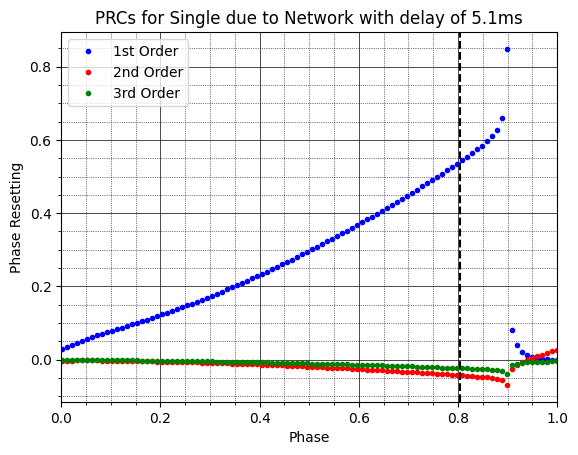

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
plt.title('PRCs for Single due to Network with delay of 5.1ms')
plt.plot(phase_single, output_single[:,1], 'b.', label='1st Order')
plt.plot(phase_single, output_single[:,2], 'r.', label='2nd Order')
plt.plot(phase_single, output_single[:,3], 'g.', label='3rd Order')
plt.axvline(x = (4.8/5.9733),color='k',linestyle='--')
plt.ylabel('Phase Resetting')
plt.xlabel('Phase')
#plt.savefig('PRC_Single_36.eps', format='eps')
plt.legend()


ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlim([0, 1])

0.803571876993235 0.7579816017316011 0.04559027526163384


(0.0, 1.0)

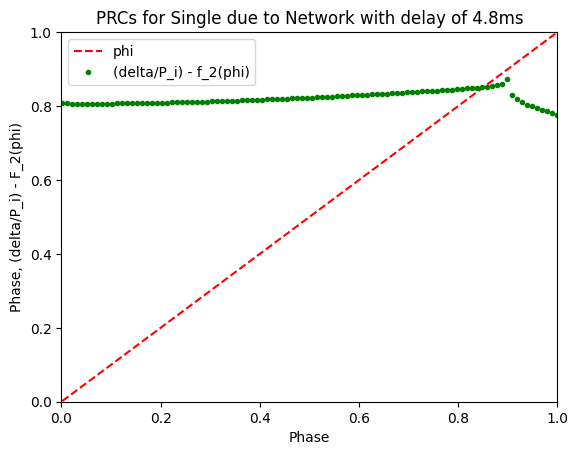

In [11]:
delay = 4.8
Stim_Phase_1 = delay/5.97333
exis = np.zeros(len(phase_single))
exis = phase_single - output_single[:,2]
Stim_array = np.zeros(len(phase_single))
for j in range(len(phase_single)):
    Stim_array[j] = delay/5.97333
for e in range(len(exis)):
    if(round(exis[e],2)==round(Stim_Phase_1,2)):
        intersection = e
        print(Stim_Phase_1,phase_single[e],Stim_Phase_1-phase_single[e])
fig = plt.figure()
ax = fig.add_subplot()
plt.title('PRCs for Single due to Network with delay of 4.8ms')
#plt.plot(phase_single, Stim_array , 'k--', label = 'delta/phi')
#plt.plot(phase_single, phase_single + output_single[:,2], 'm.', label = '(phi) - f_2(phi)')

plt.plot(phase_single, phase_single , 'r--', label = 'phi')
plt.plot(phase_single, (delay/5.97333) - output_single[:,2], 'g.', label = '(delta/P_i) - f_2(phi)')
plt.legend()
#plt.axvline(x = Stim_Phase_1,color='k',linestyle='--')
#plt.axvline(x = (phase_single[intersection]),color='b',linestyle='--')
plt.ylabel('Phase, (delta/P_i) - F_2(phi)')
plt.xlabel('Phase')
plt.xlim([0, 1])
plt.ylim([0, 1])

#plt.savefig('Self_Locking_Existence_5P4.eps', format='eps')
#plt.savefig('Self_Locking_Existence_5P4.png', format='png')

In [13]:

P_i = period_free_single
Stim_Phase_1 = delay/P_i
print(Stim_Phase_1)
index = 100*(Stim_Phase_1)
index = int(index)
print(index)
prc_value = prc_readings_single[index]
prc_value2 = prc_readings_single[index+1]
print('PRC Value at that point is ',prc_value)
diff = prc_value2 - prc_value
slope = diff/0.0101
print('The slope is ',slope)
eigen = 1-slope
print('Eigen Value ',eigen)
Network_Period = P_i*(1 + prc_value)
print('Supposed Network Period is given by, ',Network_Period)
print(P_i/Network_Period)
print(Network_Period-P_i)

0.8537946428571423
85
PRC Value at that point is  [0.59642857]
The slope is  [1.37022631]
Eigen Value  [-0.37022631]
Supposed Network Period is given by,  [9.536]
[0.62639821]
[3.56266667]
